# Cityscapes Dataset Analysis

In this notebook, we analyse the Cityscapes dataset distributed in train, tests and validation sets, available [here](https://www.cityscapes-dataset.com/downloads/). It is also needed to download the leftImg8bit set to count the number of images.

The analysis on labels and polygons will be based on the files that were generated with the scripts *generate_files.py* & *generate_fractals.py*.

## Import libraries

In [2]:
import pandas as pd
import os
import utilities
import imageio
from tabulate import tabulate
import numpy as np
import seaborn as sns
from skimage.draw import polygon
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cv2
import porespy.metrics as pm
from scipy.stats import linregress

pd.options.plotting.backend = "plotly"

## Check IDs & # Files
The code below will creates lists of all the files in the data folder containing both the gtFine and leftImg8bit datasets, in order to check the number of files for each city.

In [ ]:
comprehension = ['test', 'train', 'val']
header = ['#', 'ID gtFine', '# of File', 'ID leftlmg8bit', '# of File', "Test ID", "Test #"]

for dir in comprehension:
    print(dir.upper() + " Dir. Comprehension")
    gtFine_lst = [file for file in os.listdir('data/gtFine/' + dir) if '.DS_Store' not in file]
    gtFine_nb = [len([file for file in os.listdir('data/gtFine/' + dir + '/' + path)]) for path in gtFine_lst]
    leftlmg8bit_lst = [file for file in os.listdir('data/leftImg8bit/' + dir)]
    leftlmg8bit_nb = [len([file for file in os.listdir('data/gtFine/' + dir + '/' + path)]) for path in leftlmg8bit_lst]
    print("LEN Verification :", len(gtFine_lst) == len(leftlmg8bit_lst))

    data = [[i, gtFine_lst[i], gtFine_nb[i], leftlmg8bit_lst[i], leftlmg8bit_nb[i], gtFine_lst[i] == leftlmg8bit_lst[i], gtFine_nb[i] == leftlmg8bit_nb[i]] for i in range(len(gtFine_lst))]
    data.insert(0, header)

    print(tabulate(data, headers='firstrow', tablefmt='fancy_grid') + '\n')

TEST Dir. Comprehension
LEN Verification : True
╒═════╤═════════════╤═════════════╤══════════════════╤═════════════╤═══════════╤══════════╕
│   # │ ID gtFine   │   # of File │ ID leftlmg8bit   │   # of File │ Test ID   │ Test #   │
╞═════╪═════════════╪═════════════╪══════════════════╪═════════════╪═══════════╪══════════╡
│   0 │ bielefeld   │         724 │ bielefeld        │         724 │ True      │ True     │
├─────┼─────────────┼─────────────┼──────────────────┼─────────────┼───────────┼──────────┤
│   1 │ leverkusen  │         232 │ leverkusen       │         232 │ True      │ True     │
├─────┼─────────────┼─────────────┼──────────────────┼─────────────┼───────────┼──────────┤
│   2 │ bonn        │         184 │ bonn             │         184 │ True      │ True     │
├─────┼─────────────┼─────────────┼──────────────────┼─────────────┼───────────┼──────────┤
│   3 │ berlin      │        2176 │ berlin           │        2176 │ True      │ True     │
├─────┼─────────────┼───────────

We can confirm that there a total of 5000 images, and the corresponding number of images for each city.

## Check IMGs Size

We now need to check if every images have the same size, which is expected to be (2048x1024).

In [ ]:
comprehension = ['test', 'train', 'val']
for dir in comprehension:
    gtFine_lst = [file for file in os.listdir('data/gtFine/' + dir) if '.DS_Store' not in file]
    gtFine_file = [['data/gtFine/' + dir + '/' + path + '/' + file for file in os.listdir('data/gtFine/' + dir + '/' + path) if '.json' in file] for path in gtFine_lst]
    gtFine_size_w, gtFine_size_h = [], []
    for city in range(len(gtFine_lst)):
        city_lst_w, city_lst_h = [], []
        for file in gtFine_file[city]:
            with open(file, 'r') as f:
                data = json.load(f)
                city_lst_w.append(data['imgWidth']), city_lst_h.append(data['imgHeight'])
        gtFine_size_w.append(city_lst_w), gtFine_size_h.append(city_lst_h)
    print("Dir. " + dir + " :", (utilities.multi_mean_tuple(gtFine_size_w), utilities.multi_mean_tuple(gtFine_size_h)))

Dir. test : (2048.0, 1024.0)
Dir. train : (2048.0, 1024.0)
Dir. val : (2048.0, 1024.0)


## Load Generated Files

We load in a pandas dataframe the result of the count of labels for each file, to make easier the calculations on the data.

In [2]:
df_count = pd.read_csv('output/labels_count.csv')
df_count

,city,terrain,rider,traffic sign,license plate,road,sidewalk,vegetation,out of roi,building,...,tunnel,caravan,truck,guard rail,rectification border,rail track,train,motorcyclegroup,ridergroup,truckgroup
0,aachen,4.0,1.0,11.0,3.0,1.0,2.0,5.0,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aachen,11.0,NaN,12.0,7.0,2.0,5.0,10.0,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aachen,3.0,NaN,23.0,4.0,1.0,2.0,1.0,1,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aachen,2.0,NaN,8.0,5.0,1.0,3.0,NaN,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aachen,1.0,NaN,17.0,12.0,1.0,5.0,2.0,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,munster,NaN,2.0,13.0,2.0,1.0,4.0,12.0,1,3.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3471,munster,NaN,2.0,13.0,NaN,1.0,NaN,10.0,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3472,munster,2.0,2.0,3.0,NaN,1.0,2.0,6.0,1,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3473,munster,3.0,NaN,4.0,3.0,1.0,2.0,7.0,1,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 41 columns, including the first one that represents the city. So in total there are 40 labels in the cityscapes dataset. There are 3475 rows which is the correct number of images when counting both the train and val set. We did not include the test set because the json files for every images all contains the two same labels.

We load the result of the script file that generates the dictionary of polygons for each city. The polygons variable contains for keys each city, and for value a dictionary with the pair : (label : list[polygon]).

In [3]:
with open('output/polygons.json', 'r') as f:
        polygons = json.load(f)
print(len(polygons))

21


Finally, we load the the result of the fractal dimension computed on every image in a pandas dataframe.

In [4]:
df_fractal = pd.read_csv('output/fractal_dimension.csv')
df_fractal

,aachen,bochum,bremen,cologne,darmstadt,dusseldorf,erfurt,hamburg,hanover,jena,...,monchengladbach,strasbourg,stuttgart,tubingen,ulm,weimar,zurich,frankfurt,lindau,munster
0,1.503190,1.439892,1.425333,1.468033,1.456130,1.482640,1.521018,1.476419,1.485502,1.440682,...,1.434097,1.386579,1.341539,1.431206,1.426222,1.451299,1.440883,1.427549,1.441166,1.505937
1,1.553607,1.504202,1.430865,1.483367,1.471420,1.440586,1.465619,1.438964,1.416276,1.395833,...,1.463940,1.426501,1.440909,1.463861,1.467051,1.428250,1.490816,1.428088,1.302303,1.340061
2,1.420985,1.529835,1.411693,1.534521,1.455243,1.464034,1.450505,1.445989,1.426790,1.381436,...,1.408100,1.535084,1.486054,1.456409,1.403988,1.517585,1.492964,1.385860,1.356119,1.431308
3,1.362957,1.474775,1.392128,1.452649,1.516335,1.421237,1.391246,1.438967,1.409663,1.455051,...,1.460127,1.452942,1.445386,1.435384,1.399792,1.400279,1.496337,1.438129,1.455777,1.443150
4,1.473698,1.492498,1.429864,1.383958,1.430695,1.482503,1.380910,1.507570,1.423982,1.454675,...,1.445340,1.543118,1.482302,1.498715,1.372406,1.443019,1.389052,1.434703,1.464303,1.462725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.498522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.517367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.478750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.423125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Labels Distribution

In [4]:
all_labels_count = df_count.drop('city', axis=1).sort_index(axis=1).sum(axis=0)
all_labels_count.plot(
    kind='bar', 
    title='Labels Distribution', 
    text_auto=True, 
    labels={'index' : 'Label', 'value' : 'Count'}
    ).update_layout(showlegend=False).update_xaxes(tickangle=-60)

In this graph we can see that there are a few over-represented labels like pole, car, static, etc. Consequently, the labels distribution in the dataset is unbalanced. It is a bias in the data, that could disturb the model when training it.

## Traffic ways and vehicles distribution

In [5]:
ways = ['road', 'sidewalk', 'parking', 'rail track']
ways_count = df_count[ways].sort_index(axis=1).sum(axis=0)
ways_count.plot(
    kind='bar', 
    title='Traffic ways Distribution', 
    text_auto=True, 
    labels={'index' : 'Label', 'value' : 'Count'}
    ).update_layout(showlegend=False).update_xaxes(tickangle=-60)

When focusing on the traffic ways, we can again see the same phenomenon, there are labels that represented more than the others. It is in fact logic, because we rarely see rail tracks on roads, compared to sidewalk. So we can conclude the same as before, it can bias the model that will be more trained on the sidewalks on road than on parkings and rail tracks.

In [6]:
vehicles = ['car', 'cargroup', 'truck', 'truckgroup', 'bus', 'train', 'motorcycle', 'motorcyclegroup', 'bicycle', 'bicyclegroup', 'caravan', 'trailer']
vehicles_count = df_count[vehicles].sort_index(axis=1).sum(axis=0)
vehicles_count.plot(
    kind='bar', 
    title='Vehicles Distribution', 
    text_auto=True, 
    labels={'index' : 'Label', 'value' : 'Count'}
    ).update_layout(showlegend=False).update_xaxes(tickangle=-60)

Once more, the car label is over-represented compare to all the other vehicle labels. There are classes that present less than 100 times in the dataset. Consequently, we may need to remove these labels, like truckgroup, because it is not accurate to train the model on only one polygon for a class.

## Cities labels distribution

We now make an interactive plot where it is possible to choose the city and see the distribution for every label.

In [ ]:
# Function to generate bar plot for a given city
def generate_bar_plot(city):
    city_df = df_count[df_count['city'] == city]
    city_df = city_df.sum(axis=0).drop('city').sort_index()
    trace = go.Bar(x=city_df.index, y=city_df.values, text=city_df.values)
    return trace

# Get the list of unique cities
cities = df_count['city'].unique()

# Create the dropdown menu
dropdown_menu = [
    {
        "buttons": [
            {
                "label": city,
                "method": "update",
                "args": [{"visible": [city == c for c in cities]}, {"title": f"Labels distribution for {city}"}],
            }
            for city in cities
        ],
        "direction": "down",
        "showactive": True,
    }
]

# Create the layout with the dropdown menu
layout = go.Layout(
    title="Labels Distribution for berlin",
    updatemenus=dropdown_menu,
    xaxis=dict(title="Labels", tickangle=-60),
    yaxis=dict(title='Count')
)

# Create the subplots
fig = make_subplots(rows=1, cols=1)

# Add the bar plots for each city
for city in cities:
    fig.add_trace(generate_bar_plot(city))

# Update the layout and set the initial visibility of the traces
fig.update_layout(layout)
fig.update_traces(visible=False, showlegend=False)
fig.data[0].visible = True

# Show the final plot
fig.show()

# Labels Density

In this part, we want to create a heatmap showing the spatial distribution of the labels in the image. For that we initialize a numpy array of shape(1024, 2048) of zeros. And then, for a chosen label, we get all the polygons and increment the array by 1 with its coordiantes. It wille be useful to see how the objects are spatially distributed in all images.

In [7]:
def compute_polygon(heatmap, label, city):
    if label in polygons[city]:
            for poly in tqdm(polygons[city][label], desc=city):
                try:
                    poly = np.array(poly)
                    rr, cc = polygon(poly[:, 1], poly[:, 0])
                    heatmap[rr, cc] += 1
                except:
                    pass
    return heatmap
    
def display_heatmap(label, city):
    heatmap = np.zeros((1025, 2049))
    if city == 'all':
        for city in polygons.keys():
            heatmap = compute_polygon(heatmap, label, city)
    else:
        heatmap = compute_polygon(heatmap, label, city)
    plt.subplots(figsize=(20, 10))
    sns.heatmap(heatmap, xticklabels=False, yticklabels=False).set_title(label, fontdict={'fontsize': 20})

We made a try, except statement because we saw that for the road and the sidewalk labels, there are polygon coordinates that are out of the bounds of the images. We verified at the start that all the images have the same size. In consquence, we think that it might be a human error when the polygon were drawn by hand.

In [8]:
dd1 = widgets.Dropdown(
    options=df_count.drop('city', axis=1).columns.tolist(),
    value='rail track',
    description='Label:'
)

dd2 = widgets.Dropdown(
    options=['all'] + df_count['city'].sort_index().unique().tolist(),
    value='all',
    description='City:'
)
dropdowns = widgets.HBox([dd1, dd2])

interact(display_heatmap, label=dd1, city=dd2)

interactive(children=(Dropdown(description='Label:', index=35, options=('terrain', 'rider', 'traffic sign', 'l…

<function __main__.display_heatmap(label, city)>

We can clearly see the shape of every type of labels being distributed in the image. And we can see that images could be divided into parts where there is a bigger probability of getting a specific label. For example, if we compute it for people, we can assume that it is mostly the horizontal middle part of the image that has people object. For another one like rail tracks, it is mostly on the vertical left and right side of the image that they mostly appear.

With this in mind, we could experiment a model that would be trained on certain parts of the images for a chosen label. This specific part could be calculated using a threshold, like 50% of the labels being in it. We also could manage to do a study on spatial bias.

In [10]:
df_count['population'] = df_count['person'] + df_count['persongroup'] * 2
cities_pop = df_count.groupby('city')['population'].sum()
max_city, max_pop = max(cities_pop.items(), key=lambda x: x[1])
print('Maximum population density:', max_city, max_pop)

min_city, min_pop = min(cities_pop[cities_pop > 100].items(), key=lambda x: x[1])
print('Minimum population density:',min_city, min_pop)

Maximum population density: hamburg 2765.0
Minimum population density: monchengladbach 109.0


We can confirm this spatial distribution by computing the heatmap for the label people, on both the maximum and minimum cities in terms of number of people on the image.

hamburg: 100%|██████████| 4412/4412 [00:15<00:00, 282.37it/s]


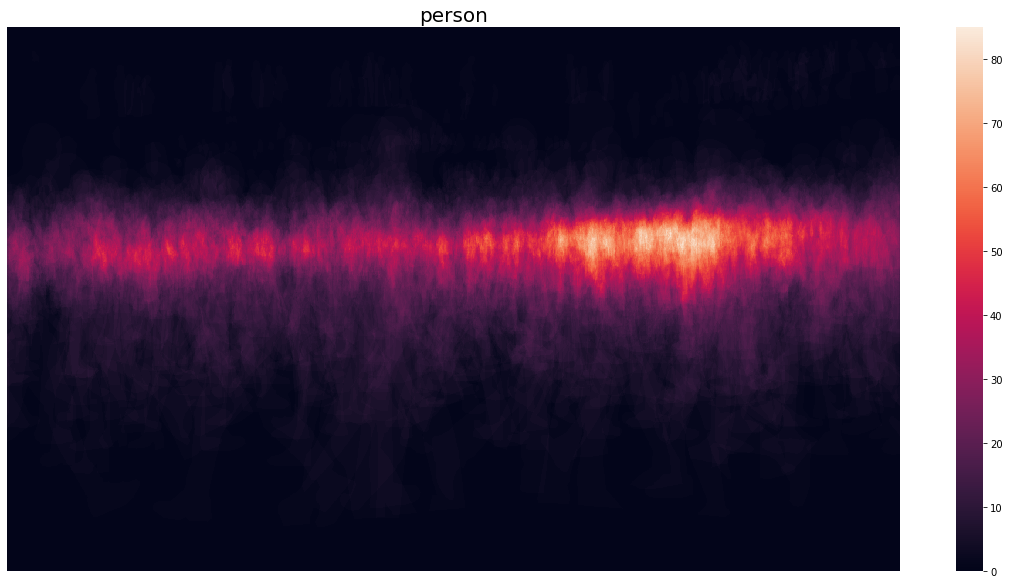

In [11]:
display_heatmap('person', max_city)

monchengladbach: 100%|██████████| 221/221 [00:00<00:00, 274.01it/s]


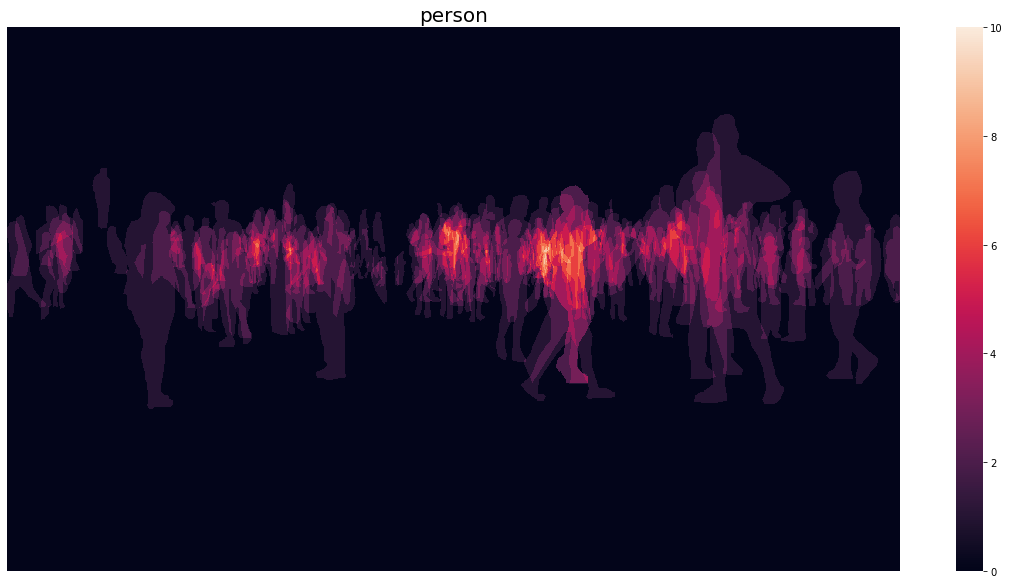

In [12]:
display_heatmap('person', min_city)

## City Labels Distribution Compared To Mean

In [53]:
labels_count_mean = df_count.sort_index(axis=1).mean(numeric_only=True)
max_count_minus_mean = (df_count[df_count['city'] == max_city] - labels_count_mean).sum(numeric_only=True)
colors = ['red' if x < 0 else 'green' for x in max_count_minus_mean]
bar = go.Bar(
    x=max_count_minus_mean.index,
    y=max_count_minus_mean.values,
    text=max_count_minus_mean.apply(lambda x: f'{x:.2f}'),
    hovertemplate='%{x}: %{y:.2f}',
    marker=dict(color=colors)
    ) 
layout = go.Layout(title='Hambourg Labels Compared To The Mean', xaxis=dict(title='Label', tickangle=-60), yaxis=dict(title='Value'))
fig = go.Figure(data=[bar], layout=layout)
fig.show()

## Images complexity

Finally, we want to check the complexity of every images. For that we will calculate the fractal dimension. It is a number that represents the complexity of a geometric object, but can also be used on pictures. There are different mathematical approaches to calculate it, but we will use the easiest one which is box counting. It consists in choosing a number of boxes to surround the image, and at each iteration, the boxes will become smaller. At the end of the algorithm, we can calculate the fractal dimension by taking the coefficient of the slope, of the size of the boxes depending on the count.

We will show a short example in this notebook, but the computation for all the images is done by the *generate_fractal.py*.

In [49]:
def fractal_dimension(path):
    city = path.split('/')[3]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    box_count = pm.boxcount(edges)
    x = np.log(box_count.size)
    y = np.log(box_count.count)
    slope = linregress(x, y).slope
    fd = -slope
    return city, fd, edges

The function takes for argument a file_path, and then returns the name of the city, the fractal dimension and the edges of the image. At the start it reads the image in grayscale, in order to compute the canny edges on it. Then it passes the result to the box count function of the porespy library. Finally, it computes the fractal dimension by taking the opposite of the slope of the box count in function of their sizes.

  0%|          | 0/10 [00:00<?, ?it/s]

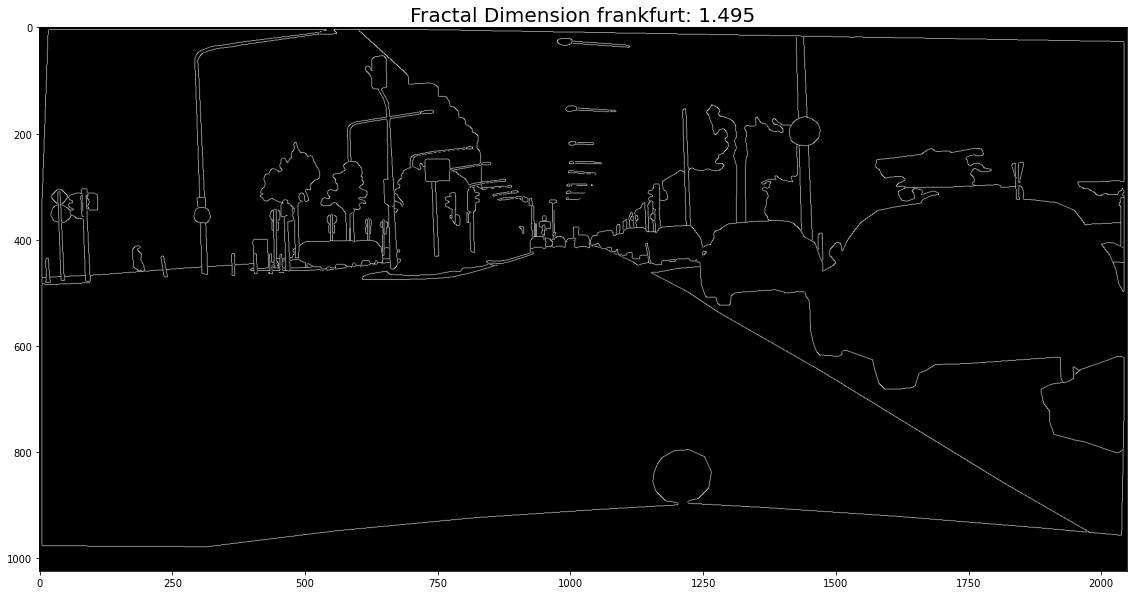

In [52]:
path = 'data/gtFine/val/frankfurt/frankfurt_000001_083852_gtFine_color.png'
city, fd, img = fractal_dimension(path)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img, cmap='gray')
ax.set_title(f'Fractal Dimension {city}: {fd:.3f}', fontsize=20)
plt.show()

We see that for a relatively complex image, the number is equel to 1.495.

Finally we can compute the mean of the fractal dimension of every images by city.

In [45]:
df_fractal.mean(axis=0)
bar = [go.Bar(x=df_fractal.columns,
              y=df_fractal.mean(axis=0),
              text=df_fractal.mean(axis=0).apply(lambda x: f'{x:.3f}'),
              marker=dict(color='#FF3D3D')
              )]
fig = go.Figure(data=bar, layout=go.Layout(title='Mean Fractal Dimension', xaxis=dict(title='City', tickangle=-60), yaxis=dict(title='Mean')))
fig.show()

We see that the numbers are almost all the same, so the standard deviation is relatively low. The city lindau seems to have a less complex image, which can be verified by seeing the plot of the distribution of labels displayed before.